# 1. Libraries & Data

In [1]:
# Load Python Libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import tqdm
from typing import Tuple, Sequence

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

pd.set_option("display.max_rows", None)

keras.utils.set_random_seed(42)

2026-01-27 15:46:40.882825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data - already rolling z normed
data = pd.read_csv('TSLA_2024_2026_1d_norm30.csv')

print(data.shape)
print(data.head())

(466, 13)
         Date       Close         MA5        MA20    BB_upper    BB_lower  \
0  2024-03-13  169.479996  175.755997  189.845499  211.725466  167.965531   
1  2024-03-14  162.500000  172.525998  188.534998  213.608030  163.461966   
2  2024-03-15  163.570007  170.172000  186.690999  213.442870  159.939128   
3  2024-03-18  173.800003  169.378000  185.383499  211.962410  158.804588   
4  2024-03-19  171.320007  168.134003  184.261500  211.243059  157.279941   

      Vol20  Close_normed  MA5_normed  MA20_normed  BB_upper_normed  \
0  0.489001     -2.173582   -2.162958    -0.863202        -0.326670   
1  0.493808     -2.526294   -2.332935    -1.060290        -0.136851   
2  0.428391     -2.144783   -2.322483    -1.403415        -0.068434   
3  0.496622     -1.151672   -2.145109    -1.706893        -0.104017   
4  0.489120     -1.307498   -2.047872    -1.986337        -0.080249   

   BB_lower_normed  Vol20_normed  
0        -1.540831     -0.251772  
1        -2.270600     -0.1653

# 2. Train / Test Split

In [3]:
# split dataset into train (80%) and test (20%) datasets

training_rows = int(len(data.index)*0.8)
train_df = data.loc[:training_rows].set_index("Date")
test_df = data.loc[training_rows+1:].set_index("Date")
print(f'training shape: ', train_df.shape)
print(f'test shape: ', test_df.shape)

print(train_df.head())

training shape:  (373, 12)
test shape:  (93, 12)
                 Close         MA5        MA20    BB_upper    BB_lower  \
Date                                                                     
2024-03-13  169.479996  175.755997  189.845499  211.725466  167.965531   
2024-03-14  162.500000  172.525998  188.534998  213.608030  163.461966   
2024-03-15  163.570007  170.172000  186.690999  213.442870  159.939128   
2024-03-18  173.800003  169.378000  185.383499  211.962410  158.804588   
2024-03-19  171.320007  168.134003  184.261500  211.243059  157.279941   

               Vol20  Close_normed  MA5_normed  MA20_normed  BB_upper_normed  \
Date                                                                           
2024-03-13  0.489001     -2.173582   -2.162958    -0.863202        -0.326670   
2024-03-14  0.493808     -2.526294   -2.332935    -1.060290        -0.136851   
2024-03-15  0.428391     -2.144783   -2.322483    -1.403415        -0.068434   
2024-03-18  0.496622     -1.1516

In [4]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)
print(f'training shape: ', train_df.shape)
print(f'test shape: ', test_df.shape)

# only use normalised data as state
mask = train_df.columns.str.endswith('_normed')
normed_cols = train_df.columns.get_indexer(train_df.columns[mask])
print(train_df.columns)
print(normed_cols)

# record real close index for reward calculation
idx_close = train_df.columns.get_loc('Close')
print(idx_close)

training shape:  (373, 12)
test shape:  (93, 12)
Index(['Close', 'MA5', 'MA20', 'BB_upper', 'BB_lower', 'Vol20', 'Close_normed',
       'MA5_normed', 'MA20_normed', 'BB_upper_normed', 'BB_lower_normed',
       'Vol20_normed'],
      dtype='object')
[ 6  7  8  9 10 11]
0


In [5]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

# Plot behavior of trade output
def plot_behavior(data_input, states_buy, states_sell, profit, train=True, save_name=None):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/2)), test_df.index.values[0::int(len(test_df.index.values)/2)], rotation=45, fontsize='small')
    plt.show()

    if save_name is not None:
        fig.savefig(save_name, bbox_inches='tight', dpi=300)


# Plot training loss
def plot_losses(losses, title):
    losses = np.array(losses)

    # Compute mean of non-zero values
    non_zero_losses = losses[losses != 0]
    mean_non_zero = non_zero_losses.mean() if non_zero_losses.size > 0 else 0

    # Plot curve
    plt.plot(losses, label="Loss")

    # Plot mean line
    plt.axhline(mean_non_zero, color="lightgrey", linestyle="--",
                label=f"Mean (non‑zero): {mean_non_zero:.4f}")

    plt.title(title)
    plt.ylabel("MSE Loss Value")
    plt.xlabel("batch")
    plt.legend()
    plt.show()


# 3. Define the Agent

In [6]:
### Reinforcement Learning Agent

# --------------
# DQN structure
# --------------
def build_dqn(state_size: int, action_size: int) -> keras.Model:
    """
    DQN with Huber + Adam(clipnorm) + LR schedule.
    Input is a flat vector of length state_size = window_size * num_features.
    """
    inputs = keras.Input(shape=(state_size,), name="state")
    x = layers.Dense(32, activation="relu")(inputs)
    x = layers.Dense(16, activation="relu")(x)
    q_values = layers.Dense(action_size, activation="linear", name="q_values")(x)
    model = keras.Model(inputs=inputs, outputs=q_values, name="DQN")

    # Exponential LR decay 
    schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=200,
        decay_rate=0.5,
        staircase=True
    )
    opt = keras.optimizers.Adam(learning_rate=schedule, clipnorm=1.0)
    model.compile(optimizer=opt, loss=keras.losses.Huber(delta=1.0))
    return model


# ---------------------------------------------
# Window utilities for (window_size > 1) usage
# ---------------------------------------------
def make_window(features_txf: np.ndarray, t: int, window_size: int) -> np.ndarray:
    """
    Build a flat state vector of shape (window_size * num_features,).

    features_txf: np.ndarray with shape (T, F) where F == num_features
    t:            current index (0-based)
    window_size:  number of past steps including current (lookback)

    Pads the left side by repeating the earliest row if there are not enough past steps.
    """
    assert features_txf.ndim == 2, f"Expected (T, F), got {features_txf.shape}"
    T, F = features_txf.shape
    start = max(0, t - window_size + 1)
    window = features_txf[start : t + 1]             # shape: (<=W, F)
    if window.shape[0] < window_size:
        # left-pad by repeating the first available frame
        pad = np.repeat(window[0:1], window_size - window.shape[0], axis=0)
        window = np.concatenate([pad, window], axis=0)  # (W, F)
    # flatten to (W*F,)
    state = window.reshape(-1).astype(np.float32)
    return state
    

# -----------------
# Double DQN Agent
# -----------------
class Agent:
    def __init__(
        self,
        window_size: int,
        num_features: int,
        batch_size: int,
        test_mode: bool = False,
        model_name: str = "",
        action_size: int = 3,  # 0=hold, 1=buy, 2=sell 
    ):
        self.window_size = window_size
        self.num_features = num_features
        self.batch_size = batch_size
        self.test_mode = test_mode
        self.action_size = action_size

        # flat state length
        self.state_size = window_size * num_features

        # replay + hyperparams
        self.memory = deque(maxlen=500)  
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.98

        self.replay_start_size = 128    # warmup 
        self.target_update_freq = 50  # sync target every N gradient steps
        self.train_steps = 0

        # main / target nets
        if test_mode and model_name:
            # load full model (architecture + weights)
            self.model = keras.models.load_model(model_name)
            self.target_model = keras.models.clone_model(self.model)
            self.target_model.set_weights(self.model.get_weights())
        else:
            self.model = self._model()
            self.target_model = keras.models.clone_model(self.model)
            self.target_model.set_weights(self.model.get_weights())

    def _model(self) -> keras.Model:
        return build_dqn(self.state_size, self.action_size)

    # ---------- state ----------
    def _flatten_state(self, s: np.ndarray) -> np.ndarray:
        """
        Ensure a flat 1-D state of length state_size.
        Accepts either (state_size,) or (window_size, num_features).
        """
        s = np.asarray(s)
        if s.ndim == 2:
            # (W, F) → flat
            s = s.reshape(-1)
        elif s.ndim == 1:
            pass
        else:
            raise ValueError(f"Unexpected state shape {s.shape}")

        if s.size != self.state_size:
            raise ValueError(f"State length {s.size} != expected {self.state_size}")
        return s.astype(np.float32)
        

    # ---------- acting ----------
    def get_q_values_for_state(self, state: Sequence[float]) -> np.ndarray:
        """
        Returns Q(s,·) for a single state. Input can be (W,F) or flat.
        """
        x = self._flatten_state(np.asarray(state)).reshape(1, -1)  # (1, state_size)
        return self.model.predict(x, verbose=0)  # (1, A)

    
    def act(self, state) -> int:
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        q = self.get_q_values_for_state(state)[0]
        return int(np.argmax(q))


    # ---------- training ----------
    def fit_model(self, X: np.ndarray, Y: np.ndarray):
        """
        X: (B, state_size), Y: (B, action_size)
        """
        assert X.ndim == 2 and X.shape[1] == self.state_size, f"X shape {X.shape} != (B,{self.state_size})"
        assert Y.ndim == 2 and Y.shape[1] == self.action_size, f"Y shape {Y.shape} != (B,{self.action_size})"
        return self.model.fit(X, Y, epochs=1, verbose=0)

    def exp_replay(self):
        """
        Double-DQN replay step.
        """
        losses = []

        # warmup
        if len(self.memory) < max(self.batch_size, self.replay_start_size):
            return losses

        # sample a minibatch
        idx = random.sample(range(len(self.memory)), k=self.batch_size)
        batch = [self.memory[i] for i in idx]
        states, actions, rewards, next_states, dones = zip(*batch)

        # stack into (B, state_size)
        s  = np.stack(states, axis=0)      # (B, S)
        sp = np.stack(next_states, axis=0) # (B, S)
        a  = np.array(actions, dtype=np.int64)     # (B,)
        r  = np.array(rewards, dtype=np.float32)   # (B,)
        d  = np.array(dones,   dtype=np.bool_)     # (B,)

        # Double-DQN: a* = argmax_a Q_online(s',a)
        q_sp_online = self.model.predict(sp, verbose=0)        # (B, A)
        a_star = np.argmax(q_sp_online, axis=1)                # (B,)

        # evaluate Q_target(s', a*)
        q_sp_target = self.target_model.predict(sp, verbose=0) # (B, A)
        max_next = q_sp_target[np.arange(self.batch_size), a_star]  # (B,)

        # Bellman target
        y = r + (~d) * (self.gamma * max_next)                 # (B,)

        # current Q(s,·) and patch chosen action
        q_s = self.model.predict(s, verbose=0)                 # (B, A)
        q_s[np.arange(self.batch_size), a] = y                 # replace only chosen actions

        # batched gradient updating step
        hist = self.fit_model(s, q_s)
        losses.append(float(hist.history["loss"][0]))

        # epsilon decay for action choosing
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # target sync
        self.train_steps += 1
        if self.train_steps % self.target_update_freq == 0:
            self.target_model.set_weights(self.model.get_weights())

        return losses

    # ---------- utils ----------
    def save(self, path: str):
        self.model.save(path)


# 4. Train the Agent

Episode 1/1:   0%|          | 0/372 [00:00<?, ?it/s]

--------------------------------
Episode 1
Total Profit:  $810.29
Total Winners: $1930.05
Total Losers:  -$1119.76
--------------------------------


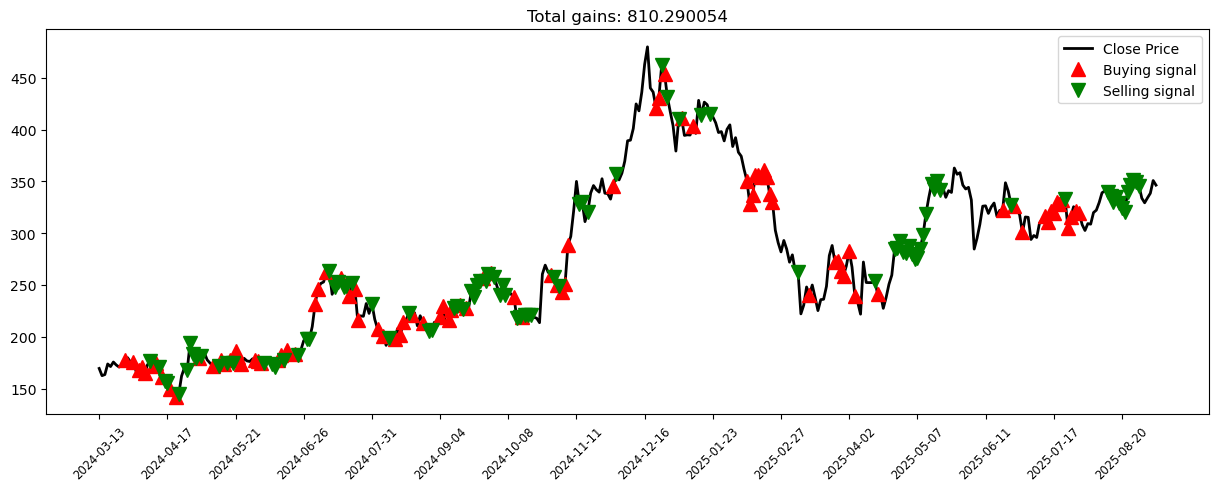

In [7]:
keras.utils.disable_interactive_logging()        # hides progress bars
keras.config.disable_traceback_filtering()       # full stack traces

sell_cost = 0.1
buy_penalty = 0.2

# hyper parameters
T = X_train.shape[0]          # number of timesteps

window_size = 5
batch_size = 32
episode_count = 1

batch_losses = []
num_batches_trained = 0

# initial agent              
agent = Agent(
    window_size=window_size,
    num_features=len(normed_cols),
    batch_size=batch_size
)


for e in range(episode_count):  

    state = make_window(X_train[:, normed_cols], t=0, window_size=window_size)

    total_profit = 0.0
    total_winners_sum = 0.0
    total_losers_sum  = 0.0
    agent.inventory = []
    states_sell, states_buy = [], []

    for t in tqdm(range(T-1), desc=f'Episode {e+1}/{episode_count}'):
        action = agent.act(state)
        
        next_state = make_window(X_train[:, normed_cols], t + 1, window_size=window_size)
        # print('action:', action)
        # print('next state shape:', next_state.shape)
        # print('next state:', next_state)

        reward = 0.0
        
        if action == 1:  # buy
            buy_price = X_train[t, idx_close]
            agent.inventory.append(buy_price)
            states_buy.append(t)

            reward = -buy_penalty # small buy penalty discourages frequent buys
            
        elif action == 2 and len(agent.inventory) > 0:  # sell
            bought_price = agent.inventory.pop(0)
            sell_price   = X_train[t, idx_close]
        
            # realized profit 
            pnl = sell_price - bought_price 
        
            reward = pnl - sell_cost
        
            # for printing & charting
            total_profit += pnl
            if pnl >= 0:
                total_winners_sum += pnl
            else:
                total_losers_sum  += pnl
            states_sell.append(t)

        done = (t == (T-2))
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # warmup until at least one full minibatch and replay_start_size
        if len(agent.memory) >= agent.batch_size:
            losses = agent.exp_replay()                 
            batch_losses.append(float(np.sum(losses)))  

        if done:
            new_losses = batch_losses[num_batches_trained:]
            max_loss = max(new_losses) if new_losses else float('nan')
            tot_loss = sum(new_losses) if new_losses else 0.0

            print('--------------------------------')
            print(f'Episode {e+1}')
            print(f'Total Profit:  {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners_sum)}')
            print(f'Total Losers:  {format_price(total_losers_sum)}')
            print('--------------------------------')

            plot_behavior(
                X_train[:, idx_close].flatten(),
                states_buy,
                states_sell,
                total_profit,
                save_name=f'model_ep{e+1}.png'
            )
            # plot_losses(new_losses, f'Episode {e+1} DQN model loss')
            num_batches_trained = len(batch_losses)

    agent.model.save(f'model_window{window_size}_ep{e+1}.keras')


# 5. Test the model 

------------------------------------------
Total Profit: $676.94
------------------------------------------


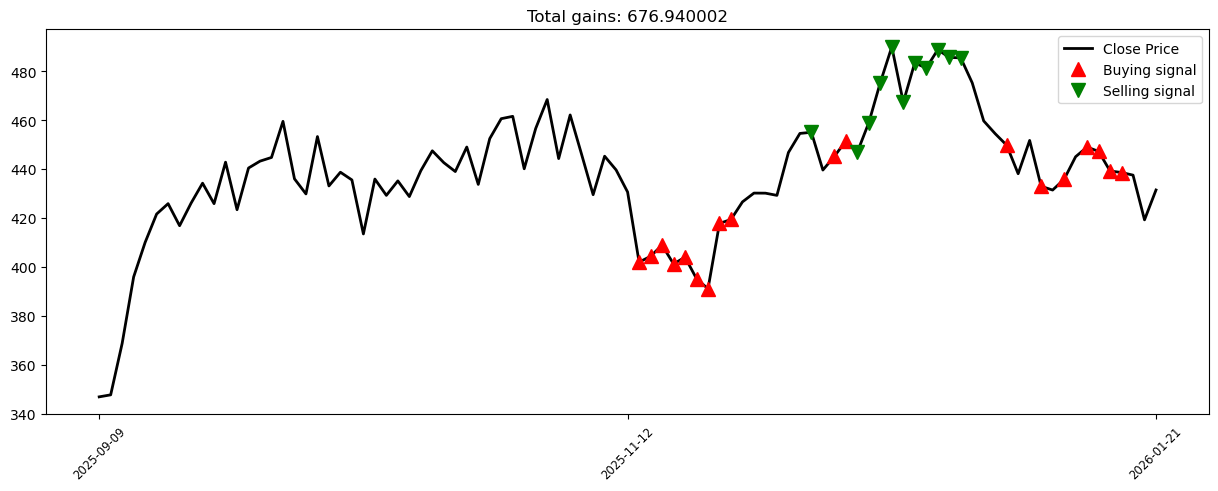

In [8]:
trade_df = pd.DataFrame(columns = ['Buy Price', 'Buy Timestamp', 'Sell Price', 'Sell Timestamp'])

l_test = len(X_test) - 1
state = make_window(X_test[:, normed_cols],0, window_size=window_size)

total_profit = 0
states_sell_test = []
states_buy_test = []


# Load trained model
agent = Agent(
    window_size = window_size,
    num_features=len(normed_cols),
    batch_size = batch_size,
    test_mode=True,
    model_name=f'model_window{window_size}_ep{e+1}.keras'
)

agent.inventory = []

for t in range(l_test):

    action = agent.act(state)
    # print(t, agent.get_q_values_for_state(state), action)
    next_state = make_window(X_test[:, normed_cols], t + 1, window_size=window_size)

    reward = 0.0

    # buy
    if action == 1: 
        buy_price = X_test[t, idx_close]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        # print(f"Buy: {format_price(buy_price)}")

        trade_df.loc[len(states_buy_test), "Buy Price"] = buy_price
        trade_df.loc[len(states_buy_test), "Buy Timestamp"] = test_df.index[t]

    # sell
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        sell_price = X_test[t, idx_close]
        trade_profit = sell_price - bought_price
        reward = max(trade_profit, 0)
      
        total_profit += trade_profit
        states_sell_test.append(t)
        # print(f"Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}")

        trade_df.loc[len(states_sell_test), "Sell Price"] = sell_price
        trade_df.loc[len(states_sell_test), "Sell Timestamp"] = test_df.index[t]

    # END OF EPISODE CHECK
    done = (t == l_test - 1)

    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')

# Plot
plot_behavior(
    X_test[:, idx_close].flatten(),
    states_buy_test,
    states_sell_test,
    total_profit,
    train=False
    #save_name='model_test.png'
)
